# Part 5: Identifying Bias in Gender Classification

Imagine an **automated HR system** that analyzes application photos to **predict the applicant's gender**. The company uses this information to track diversity statistics or to match candidates with gender-specific support programs.

At first this may seem harmless. However, if the model systematically misclassifies trans individuals or People of Color, they might be excluded from such programs, misrepresented in statistics, or addressed incorrectly.

In this case, it's not about deciding *for* or *against* someone (like in student support models), but about how individuals are **represented** by the system. This leads us to a different fairness concern.

---

## Decision (or Distributive) Fairness vs. Representational Fairness<sup>1</sup>

Most fairness discussions in machine learning focus on **decision fairness**:  
Is a model making **equitable decisions** for different demographic groups?

For example:
- Are women and men equally likely to receive a loan if equally qualified?
- Do people of color experience higher false positive rates in recidivism predictions?

In these cases, the **sensitive attribute (e.g., gender, race)** is an **input** — and the model is predicting a **neutral target** (e.g., risk, success, eligibility).

Fairness metrics like **Demographic Parity**, **Equal Opportunity**, or **Equalized Odds** are used to assess whether decisions or errors are **fairly distributed across groups**.

---

### Representational Fairness: A Different Problem<sup>1</sup>

In **representational fairness**, the situation is reversed:
> The **sensitive attribute** (e.g. gender) is not an input — it’s the **prediction target**.

The model isn’t deciding something *about* a person, it’s trying to recognize or classify **who someone is**.

This applies to tasks like:
- Gender classification
- Face recognition
- Emotion detection
- Attribute classification (e.g. age, skin tone)

Here, fairness is about whether the model performs **consistently across demographic groups** — not whether it makes “fair decisions.”

---

### How to Evaluate Representational Fairness

We don’t optimize for fairness constraints.  
Instead, we use **diagnostic performance metrics** to assess **bias in representation**.
These metrics (see Table below) help identify **where** the model may fail **for whom**.

Among the observational notions of fairness, only **separation-based metrics** are useful, because they compare **error rates** across groups.  
This is exactly what representational fairness is concerned with.


| Metric | Purpose |
|--------|---------|
| **Accuracy per group** | Measures overall model performance for each demographic group |
| **False Negative Rate per group** (Separation) |  Who is most often misclassified as not belonging to their actual group? |
| **False Positive Rate per group** (Separation) | Who is most often wrongly assigned to a group? |
| **Equalized Odds** (Separation) | Are both FNR and FPR equal across groups? |
| **ROC Curves per group** | Shows differences in sensitivity (TPR) and specificity (TNR) |
| **Confusion Matrix per group** | Reveals patterns in specific misclassifications |

---

### What Doesn’t Work Well Here?

Some fairness metrics are **not appropriate** for representational fairness problems:

| Metric | Why not? |
|--------|----------|
| **Demographic Parity**  | Assumes equal predicted class distribution, which is not meaningful if class distributions are unequal or if the target is the sensitive attribute itself |
| **Predictive Parity**  | Hard to interpret meaningfully when predicting identity attributes |
| **Calibration**  | Requires probabilistic outputs, which are not available in most classification APIs like DeepFace or OpenCV |

---

### Final Takeaway

> **Representational fairness isn’t about who gets what — it’s about who gets seen, and how.**  
> Fairness here means that a model recognizes people from all groups **equally well**, not that it distributes opportunities or resources.

---

## Datasets to Evaluate Model Performance

To examine fairness in gender classification, we begin by comparing two datasets:

- **FairFace**:
  A dataset with a **balanced distribution** across **ethnicity and gender**, curated specifically for fairness research.<sup>2</sup>
- **UTKFace**:
  A **realistic but more imbalanced dataset**, containing a wide variety of ages, image qualities, and labeling inconsistencies.<sup>3</sup>

This initial comparison allows us to identify **disparities in model performance** and understand how **representation and data quality** influence results.

Later, we introduce a **manually curated subset** of UTKFace to simulate a controlled real-world scenario.

---

First we import the necessary libraries. Use pip install for packages you do not have (to import cv2 you have to use 'pip install opencv-python').

> **Note**: This notebook uses TensorFlow, which is officially supported only for Python versions 3.8 to 3.11. Please ensure your Python version is compatible.

---

In [1]:
import os
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from deepface import DeepFace
from tqdm import tqdm
from sklearn.metrics import accuracy_score, confusion_matrix

---

### Load Data

Next we load and prepare the two datasets used for fairness evaluation.
Each image is labeled with gender and race to allow subgroup-level performance analysis later.

Make sure to **adjust the folder paths** to the storage location on your machine.  
If the image processing takes too long on your machine, consider **reducing the number of samples per group** to speed things up.

---

In [2]:
# Image Folders 
images_fairface = r'C:\Users\lukas\Desktop\Fairness_Notebook\Data\GenderClassification_Study\fairface-img-margin025-trainval\val' # Adjust to your path 
metadata_fairface = r'C:\Users\lukas\Desktop\Fairness_Notebook\Data\GenderClassification_Study\fairface_label_val.csv' # Adjust to your path

images_utk = r'C:\Users\lukas\Desktop\Fairness_Notebook\Data\GenderClassification_Study\UTKFace' # Adjust to your path

# Load FairFace-Metadata
df_fairface = pd.read_csv(metadata_fairface)

# Adjust column names
df_fairface = df_fairface.rename(columns={'file': 'image', 'gender': 'true_gender', 'race': 'true_race'})

# DeepFace expects "Man" or "Woman" so change "Male" to "Man" and "Female" to "Woman"
df_fairface['true_gender'] = df_fairface['true_gender'].map({'Male': 'Man', 'Female': 'Woman'})

# Complete image paths
df_fairface['image_path'] = df_fairface['image'].apply(lambda x: os.path.join(images_fairface, x.replace('val/', '')))

print('FairFace:', df_fairface['true_race'].value_counts())

# Sample 100 images per ethnicity
df_fairface = df_fairface.groupby('true_race').sample(n=100, random_state=42).reset_index(drop=True)


# Extract UTKFace ethnicity and gender labels from filenames
utk_data = []
for filename in os.listdir(images_utk):
    # UTKFace filenames have format: age_gender_race_(...).jpg
    name_parts = filename.split("_")
    # Make sure filename has age, gender, and race information
    if len(name_parts) >= 3:
        gender = int(name_parts[1]) # 0 = Man, 1 = Woman
        race = int(name_parts[2]) # 0 = White, 1 = Black, 2 = Asian, 3 = Indian
        full_path = os.path.join(images_utk, filename)
        utk_data.append([full_path, gender, race])

# Create DataFrame
df_utk = pd.DataFrame(utk_data, columns=['image_path', 'true_gender', 'true_race'])

# Assign labels
ethnicity_mapping = {0: 'White', 1: 'Black', 2: 'Asian', 3: 'Indian'}
gender_mapping = {0: 'Man', 1: 'Woman'}

df_utk['true_race'] = df_utk['true_race'].map(ethnicity_mapping)
df_utk['true_gender'] = df_utk['true_gender'].map(gender_mapping)
df_utk['ethnicity_gender'] = df_utk['true_race'] + ' ' + df_utk['true_gender']

print('UTKFace:', df_utk['true_race'].value_counts())

# Sample 200 images per ethnicity
df_utk = df_utk.groupby('true_race').sample(n=200, random_state=42).reset_index(drop=True)

# Overview
print('FairFace images loaded:', len(df_fairface))
print('UTKFace images loaded:', len(df_utk))

FairFace: true_race
White              2085
Latino_Hispanic    1623
Black              1556
East Asian         1550
Indian             1516
Southeast Asian    1415
Middle Eastern     1209
Name: count, dtype: int64
UTKFace: true_race
White     10078
Black      4526
Indian     3975
Asian      3434
Name: count, dtype: int64
FairFace images loaded: 700
UTKFace images loaded: 800


---

## Model 1: DeepFace Gender Classification<sup>4</sup>

We now analyze gender classification performance using the **DeepFace** library.

For each of the three datasets, we evaluate the model across several dimensions:

- **Confusion matrices**
- **Overall accuracy**
- **Accuracy per gender and per ethnicity**
- **Accuracy by ethnicity × gender subgroup**
- **False Positive Rate** and **False Negative Rate** per group

This allows us to assess **representational fairness** by measuring whether DeepFace performs consistently across demographic groups or whether some individuals are systematically misclassified.

We start with applying the model to both datasets. Depending on your system this can take up to 10 minutes for each dataset. You can reduce the number of samples above to reduce the time.

---

In [3]:
def predict_gender_deepface(df, image_col='image_path'):
    predictions = []

    # Iterate over each image in the dataset with a progress bar (tqdm)
    for _, row in tqdm(df.iterrows(), total=len(df), desc='DeepFace Prediction'):
        try:
            # Analyze the image using DeepFace and extract the predicted gender
            result = DeepFace.analyze(row[image_col], actions=['gender'], enforce_detection=False)
            predictions.append(result[0]['dominant_gender'])
        except:
            # If analysis fails (e.g. no face detected) append None
            predictions.append(None)

    # Add predictions to the DataFrame        
    df['predicted_gender'] = predictions

    # Drop rows where prediction failed
    return df.dropna(subset=['predicted_gender'])

# Apply model to both datasets
df_fairface = predict_gender_deepface(df_fairface)
df_utk = predict_gender_deepface(df_utk)

DeepFace Prediction: 100%|██████████| 800/800 [03:36<00:00,  3.70it/s]


---

### Confusion Matrices

Next we evaluate performance with the help of confusion matrices.

---

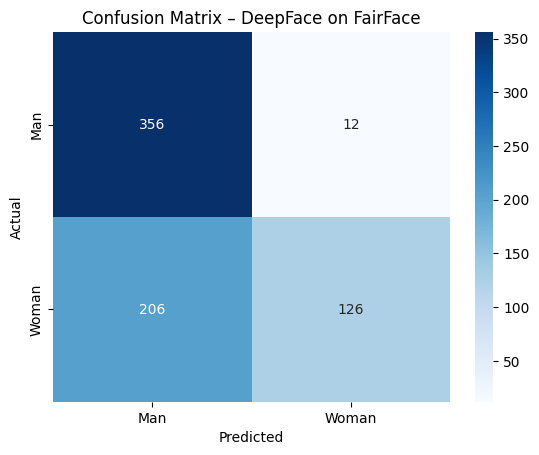

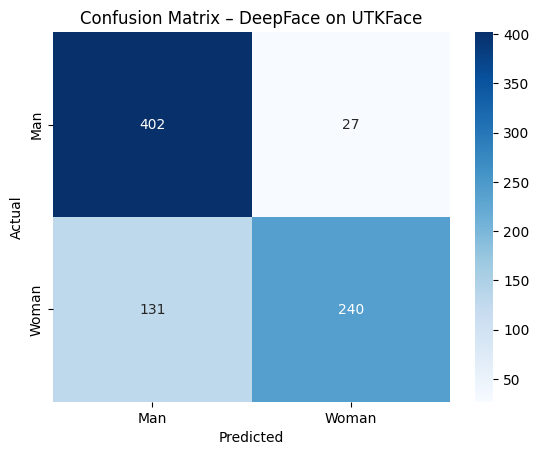

In [4]:
def plot_confusion_matrix(df, title):
    cm = confusion_matrix(df['true_gender'], df['predicted_gender'], labels=['Man', 'Woman'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Man', 'Woman'],
                yticklabels=['Man', 'Woman'])
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

plot_confusion_matrix(df_fairface, title='Confusion Matrix – DeepFace on FairFace')
plot_confusion_matrix(df_utk, title='Confusion Matrix – DeepFace on UTKFace')

---

### First Observations from Confusion Matrices

Both datasets show a similar pattern in DeepFace’s gender predictions:

- **Women (positive class)** are more often **misclassified**  than men.
- The number of **false negatives (FN)** (women predicted as men) is way **higher** than false positives (FP).

This suggests that the model struggles more to correctly identify women than men. In the FairFace dataset this imbalance seems the be even stronger.

These inital findings raise concerns about **representational fairness** and will now be explored in more detail using **accuracy, error rates and intersectional evaluation**. 

---

In [5]:
def evaluate_gender_classification(df, dataset_name):
    print('Evaluation Results for', dataset_name)
    
    # Overall Accuracy
    acc_overall = accuracy_score(df['true_gender'], df['predicted_gender'])
    print('Overall Accuracy:', round(acc_overall, 3))

    # Mark correct predictions
    df['correct'] = df['true_gender'] == df['predicted_gender']

    # Accuracy by Gender
    acc_gender = df.groupby('true_gender')['correct'].mean()
    print('\nAccuracy by Gender:')
    print(round(acc_gender, 3))

    # Accuracy by Ethnicity
    acc_ethnicity = df.groupby('true_race')['correct'].mean()
    print('\nAccuracy by Ethnicity:')
    print(round(acc_ethnicity, 3))

    # Accuracy by Ethnicity × Gender
    acc_ethn_gend = df.groupby(['true_race', 'true_gender'])['correct'].mean()
    print('\nAccuracy by Ethnicity × Gender:')
    print(round(acc_ethn_gend, 3))

    # Convert to binary to compute FNR & FPR
    df_bin = df.copy()
    df_bin['true_gender_bin'] = df_bin['true_gender'].map({'Man': 0, 'Woman': 1})
    df_bin['predicted_gender_bin'] = df_bin['predicted_gender'].map({'Man': 0, 'Woman': 1})

     # Compute FNR & FPR
    def compute_fnr_fpr(sub_df):
        tn, fp, fn, tp = confusion_matrix(sub_df['true_gender_bin'], sub_df['predicted_gender_bin']).ravel()
        fnr = fn / (tp + fn)
        fpr = fp / (fp + tn)
        return pd.Series({'FNR': round(fnr, 3), 'FPR': round(fpr, 3)})

    fnr_fpr_by_ethnicity = df_bin.groupby('true_race').apply(compute_fnr_fpr)

    print('\nFNR & FPR by Ethnicity:')
    print(fnr_fpr_by_ethnicity, '\n')

# Apply evaluation funtion to datasets
evaluate_gender_classification(df_fairface, dataset_name='FairFace')
evaluate_gender_classification(df_utk, dataset_name='UTKFace')

Evaluation Results for FairFace
Overall Accuracy: 0.689

Accuracy by Gender:
true_gender
Man      0.967
Woman    0.380
Name: correct, dtype: float64

Accuracy by Ethnicity:
true_race
Black              0.56
East Asian         0.75
Indian             0.65
Latino_Hispanic    0.72
Middle Eastern     0.81
Southeast Asian    0.59
White              0.74
Name: correct, dtype: float64

Accuracy by Ethnicity × Gender:
true_race        true_gender
Black            Man            0.941
                 Woman          0.163
East Asian       Man            0.918
                 Woman          0.588
Indian           Man            0.962
                 Woman          0.312
Latino_Hispanic  Man            0.939
                 Woman          0.510
Middle Eastern   Man            1.000
                 Woman          0.406
Southeast Asian  Man            1.000
                 Woman          0.212
White            Man            1.000
                 Woman          0.469
Name: correct, dtype: flo

---

### Interpretation: DeepFace Performance on FairFace vs. UTKFace

We applied DeepFace to two datasets with different characteristics and found **consistent bias**, but also **important differences**:

#### Overall Accuracy
- UTKFace achieves **higher overall accuracy (80.2%)** compared to FairFace (68.9%)
- However, this is **not necessarily a sign of better fairness**

#### Gender Disparities
- In both datasets, the model performs **significantly better for men**:
    - **FairFace**: Men = 96.7%, Women = **38%**
    - **UTKFace**: Men = 93.7%, Women = **64.7%**
- FairFace: The model misclassifies **more than 60% of women**

#### Ethnic & Intersectional Patterns
- In **FairFace**, some of the worst-performing subgroups include:
    - **Black Women** → 16.3% accuracy
    - **Southeast Asian Women** → 21.2%
    - **Indian Women** → 31.2%
- In contrast, **White Men consistently achieve 100% accuracy**
- **False Negative Rates** (women being classified as men) are alarmingly high for Black (83.7%), Southeast Asian (78.8%), and Indian women (68.8%)

#### UTKFace Comparison
- While UTKFace shows **better overall performance**, the patterns remain:
    - Accuracy is still highest for **men**
    - Accuracy for **Black women** is again low (51.0%)
    - FNRs for women are lower than in FairFace, but **still substantial**

#### Takeaway
DeepFace works almost perfectly for **dominant groups** like White Men, but fails dramatically for **marginalized subgroups** — particularly **Women of Color**.

>This is a clear example of **representational unfairness**:  
>The model doesn't make unfair decisions — it **fails to recognize certain people at all**.

---

### Why We Need a Clean Subset

These results highlight a key challenge:

> Model performance is not just a function of architecture — it is heavily influenced by **data quality**, **group representation**, and **label noise**.

Both datasets suffer from issues that may **exaggerate** fairness problems:
- Uncontrolled variations in pose, lighting, and expression
- Unequal representation of age, ethnicity, and gender combinations
- Mislabeled or ambiguous images

---

### Motivation: A Realistic Evaluation Scenario

To isolate the model's behavior from such noise, we introduce a **manually curated subset** of UTKFace → UTKFace adjusted.  
This subset better reflects the kind of conditions an **automated HR tool** might operate under:

- Frontal, well-lit images
- Neutral expressions
- Balanced distribution of gender and ethnicity
- Age range limited to 16–70 years

This allows us to answer a critical question:

> **Can we still observe representational bias under more controlled and "realistic" conditions?**

We will now load the adjusted dataset and look at the results.

---

In [6]:
# Image Folder
images_utk_adj = r'C:\Users\lukas\Desktop\Fairness_Notebook\Data\GenderClassification_Study\UTKFace_Adjusted' # Adjust to your path

# Extract UTKFace ethnicity and gender labels from filenames
utk_data_adj = []
for filename in os.listdir(images_utk_adj):
    name_parts = filename.split("_")
    if len(name_parts) >= 3:
        gender = int(name_parts[1])
        race = int(name_parts[2]) 
        full_path = os.path.join(images_utk_adj, filename)
        utk_data_adj.append([full_path, gender, race])

# Create DataFrame
df_utk_adj = pd.DataFrame(utk_data_adj, columns=['image_path', 'true_gender', 'true_race'])

# Assign labels
df_utk_adj['true_race'] = df_utk_adj['true_race'].map(ethnicity_mapping)
df_utk_adj['true_gender'] = df_utk_adj['true_gender'].map(gender_mapping)
df_utk_adj['ethnicity_gender'] = df_utk_adj['true_race'] + ' ' + df_utk_adj['true_gender']

print('UTKFaceAdjusted-Bilder geladen:', len(df_utk_adj))

UTKFaceAdjusted-Bilder geladen: 880


---

### Evaluation UTKFace adjusted

We now apply the model and use our functions to compute the **confusion matrix** and **performance metrics**.

---

DeepFace Prediction: 100%|██████████| 880/880 [03:55<00:00,  3.73it/s]


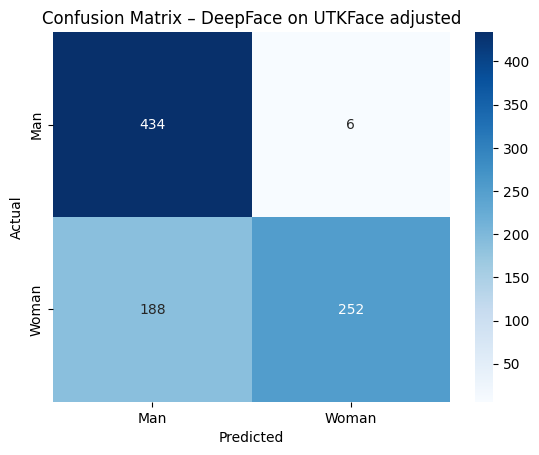

Evaluation Results for UTKFace adjusted
Overall Accuracy: 0.78

Accuracy by Gender:
true_gender
Man      0.986
Woman    0.573
Name: correct, dtype: float64

Accuracy by Ethnicity:
true_race
Asian     0.773
Black     0.682
Indian    0.720
White     0.941
Name: correct, dtype: float64

Accuracy by Ethnicity × Gender:
true_race  true_gender
Asian      Man            0.955
           Woman          0.591
Black      Man            1.000
           Woman          0.364
Indian     Man            1.000
           Woman          0.445
White      Man            0.991
           Woman          0.891
Name: correct, dtype: float64

FNR & FPR by Ethnicity:
             FNR    FPR
true_race              
Asian      0.409  0.045
Black      0.636  0.000
Indian     0.555  0.000
White      0.109  0.009 



In [7]:
# Apply model
df_utk_adj = predict_gender_deepface(df_utk_adj)

# Confusion Matrix
plot_confusion_matrix(df_utk_adj, title='Confusion Matrix – DeepFace on UTKFace adjusted')

# Evaluation
evaluate_gender_classification(df_utk_adj, dataset_name='UTKFace adjusted')

---

### Bias Is Structural

Even under **controlled conditions** (frontal, high-quality, balanced images) DeepFace continues to show **strong disparities** in performance across demographic groups.

#### Key Findings

- **White Women** benefit from improved data: Accuracy rises to **89.1%**
- But **Black and Indian Women** still suffer from **major recognition failures**
- **The gender gap is smaller** for White individuals, but persists for others

This suggests that:

> **The bias is not just due to bad data — it’s embedded in the model's behavior.**

---

### Group Comparison Table

| Metric                    | FairFace   | UTKFace   | UTK Adjusted |
|---------------------------|------------|-----------|---------------|
| Accuracy (Women overall) | 38%      | 64.7%     | 57.3%         |
| Accuracy (Black Women)   | 16.3%    | 51.0%     | 36.4%       |
| Accuracy (White Women)   | 46.9%      | 75.6%     | 89.1%       |

This reinforces the importance of:
- **Intersectional evaluation**
- **Group-level fairness diagnostics**
- And the need for **representational fairness** — not just high accuracy

---

## Model 2: OpenCV Gender Classification<sup>5</sup>

In this second model, we evaluate gender classification using a pre-trained **OpenCV model**.  
This model is less complex than DeepFace and was trained on a different dataset (Adience). It serves as a useful **baseline** to compare performance and bias.

We apply it to the **adjusted UTKFace subset**, using the same evaluation procedure as before. This allows us to find out whether the observed bias patterns are specific to DeepFace or **persist across different model architectures**.

---

In [9]:
# Load OpenCV Gender Classification Model, adjust to your paths
gender_net = cv2.dnn.readNetFromCaffe(
    r'C:\Users\lukas\Desktop\Fairness_Notebook\Data\GenderClassification_Study\OpenCV_Model\deploy_gender.prototxt', # Adjust to your path
    r'C:\Users\lukas\Desktop\Fairness_Notebook\Data\GenderClassification_Study\OpenCV_Model\gender_net.caffemodel'   # Adjust to your path
)

# Mapping of OpenCV classes 
GENDER_LIST = ['Man', 'Woman']

# 
def predict_gender_opencv(df, image_col='image_path'):
    predictions = []
    
    # Iterate over each image in the dataset with a progress bar (tqdm)
    for _, row in tqdm(df.iterrows(), total=len(df), desc='OpenCV Gender Prediction'):
        try:
            # Load the image
            image = cv2.imread(row[image_col])
            if image is None:
                predictions.append(None)
                continue

            # OpenCV expects 227x227 BGR-pictures with specific mean subtraction
            blob = cv2.dnn.blobFromImage(
                image,
                scalefactor=1.0,
                size=(227, 227),
                mean=(78.426, 87.768, 114.895), # BGR mean values from ImageNet - make sure that input format matches the model’s original training conditions
                swapRB=False, # No transformation to RGB
                crop=False
            )

            # Run prediction using the gender model
            gender_net.setInput(blob)
            preds = gender_net.forward()
            predictions.append(GENDER_LIST[preds[0].argmax()]) # "Man" or "Woman"

        except Exception:
            predictions.append(None)
    
    # Add predictions to DataFrame and drop failed entries
    df['predicted_gender'] = predictions
    return df.dropna(subset=['predicted_gender'])

# Apply model on copy of utk_adj
df_utk_adj_opencv = predict_gender_opencv(df_utk_adj.copy())

# Evaluation
evaluate_gender_classification(df_utk_adj_opencv, dataset_name='UTK adjusted (OpenCV)')

OpenCV Gender Prediction: 100%|██████████| 880/880 [00:10<00:00, 83.61it/s]

Evaluation Results for UTK adjusted (OpenCV)
Overall Accuracy: 0.85

Accuracy by Gender:
true_gender
Man      0.945
Woman    0.755
Name: correct, dtype: float64

Accuracy by Ethnicity:
true_race
Asian     0.814
Black     0.777
Indian    0.876
White     0.932
Name: correct, dtype: float64

Accuracy by Ethnicity × Gender:
true_race  true_gender
Asian      Man            0.927
           Woman          0.700
Black      Man            0.964
           Woman          0.591
Indian     Man            0.954
           Woman          0.800
White      Man            0.936
           Woman          0.927
Name: correct, dtype: float64

FNR & FPR by Ethnicity:
             FNR    FPR
true_race              
Asian      0.300  0.073
Black      0.409  0.036
Indian     0.200  0.046
White      0.073  0.064 



---

### Model 2 (OpenCV): Improved Performance, Persistent Bias

The OpenCV model achieves **higher overall accuracy (85.0%)** than DeepFace on the same clean dataset and shows **less extreme disparities** across demographic groups.

#### Key Improvements Compared to DeepFace:
- **Women overall**: 75.5% (vs. 57.3% with DeepFace)
- **Black Women**: 59.1% (vs. 36.4%)
- **Indian Women**: 80% (vs. 44.5%)
- **White Women**: 92.7% (vs. 89.1%)

#### Interpretation:
- The **gender gap** is smaller, especially for **White and Indian women**
- **False Negative Rates** (misclassifying women) are lower across all groups
- Overall, the OpenCV model is **less biased**, especially in intersectional performance

---

### But Bias Still Exists

Despite improvements, **representational unfairness remains**:
- Accuracy for **Black Women** is still lowest (59.1%)
- FNR for **Black Women** remains relatively high (40.9%)
- Model still performs **best for White individuals** across the board

This shows that:

> Even simpler models trained on different data show similar patterns —  
> suggesting that **bias is a broader, structural issue**, not just specific to DeepFace.

---

### Summary Table: DeepFace vs. OpenCV on Clean Subset

| Metric                   | DeepFace | OpenCV |
|--------------------------|----------|--------|
| Accuracy (Women overall) | 57.3%  | 75.5%  |
| Accuracy (Black Women)   | 36.4%  | 59.1%  |
| Accuracy (White Women)   | 89.1%  | 92.7%  |

While OpenCV clearly improves recognition for marginalized groups,  
**performance gaps persist — particularly for Women of Color**.

**Bias is reduced, but not resolved.**

#### Reflection:
*Would you use one of the models for the automated HR tool, that sorts applicant photos per gender?*

---

### Chapter Summary: Bias in Gender Classification

In this chapter, we examined how bias can manifest in **face-based gender classification models**, even when no explicit decision is made.

We compared two models across three datasets with varying quality and composition.  
The results revealed a consistent pattern:

- Models perform **well for dominant groups** (especially White men)
- But **fail disproportionately** for **Women of Color**
- Even under controlled conditions, **representation bias persists**
- Some subgroups (e.g. Black women) are consistently **misclassified**

This is a clear example of **representational unfairness**.
A model that **"works well on average"** but performs **poorly for specific identities** can still be deeply unfair.

#### Reflection:
*Which types of bias occurred in this example?*

---

### Relevant types of bias

Several forms of bias were present in this gender classification task:<sup>6</sup>

- **Historical Bias**: The model reflects **societal stereotypes** and **structural inequalities** — for example, limited representation of Women of Color in online image datasets and binary gender norms
- **Representation Bias**: Some subgroups (e.g. Black women) are **underrepresented** or appear in lower quality in training and test data, leading to poor recognition performance
- **Evaluation Bias**: Fairness assessments **vary across datasets** used for evaluation
- **Aggregation Bias**: Looking only at **overall accuracy** hides performance gaps (differences only visible through intersectional analysis)
- **Measurement Bias**: Inconsistent labels or image quality

---

### Looking Ahead: When Bias Reinforces Itself

Up to now, we’ve analyzed fairness issues based on **group-wise model performance**.  
But what happens when these biases do **not just reflect**, but actually **shape future outcomes**?

In the next section, we explore **Self-Fulfilling Predictions** and **Feedback Loops**:

> How do biased predictions (e.g. in policing or education) influence behavior, resource allocation, or social outcomes?  
> And how can this lead to a **reinforcement of existing inequality**?

We’ll see how machine learning models can **amplify the very problems they aim to solve.**

---

### Quiz

**1. True or False:**
Representational fairness evaluates whether model decisions are distributed fairly across groups.
1. [ ] True
2. [ ] False

**2. What makes representational fairness different from decision fairness?**
*(Select one option)*

1. [ ] It applies only to classification tasks like loan approval
2. [ ] It focuses on equal outcomes rather than equal recognition
3. [ ] It relies solely on demographic parity
4. [ ] It asks whether people are fairly represented, not fairly treated

**3. Which of the following best describes a key finding from the Gender identification evaluation?**
*(Select one option)*

1. [ ] Accuracy was highest for intersectional minority groups
2. [ ] Women were more often misclassified than men, especially Women of Color
3. [ ] DeepFace failed mostly due to low image quality
4. [ ] The model performed best when sensitive attributes were used as input

---

#### Sources:
1. Binns, 2018
2. Karkkainen & Joo, 2021
3. UTKFace Dataset, n.d.
4. Taigman et al., 2014
5. Levi & Hassner, 2015
6. Suresh & Guttag, 2021